# **Task 1**

In [2]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 43.5 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyspark: filename=pyspark-3.5.4-py2.py3-none-any.whl size=317849768 sha256=6900a89f0bd7819fbebbc4b17ab20b0aaa0b7eaa5043b05c8bdd53df4c6ead28
  Stored in directory: /home/codespace/.cache/pip/wheels/13/92/64/da92a3521323cc629fdf25dd56eb26938e08014c1b57ad3759
Successfully built pyspark


In [3]:
!pip install scikit-learn

There are 35497 rows of data as standard
There are 35497 rows of data after dropping empty data
There are 35494 rows of data after dropping duplicates
There are 1853 rows of data as standard
There are 1853 rows of data after dropping empty data
There are 1853 rows of data after dropping duplicates
DataFrame[UserID: int, ItemID: int, Rating: float]


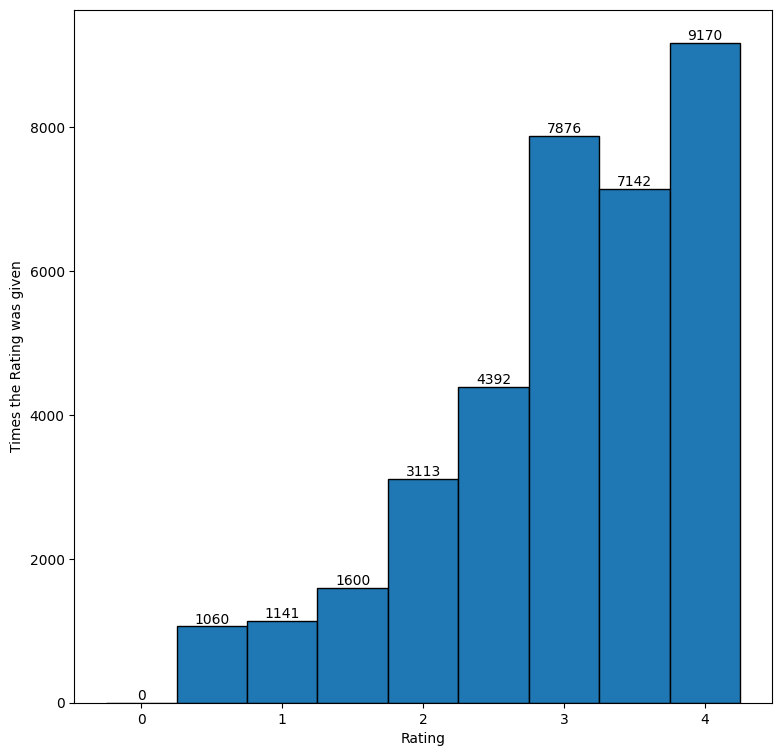

Top 5 films
+------+------------------+------------+
|ItemID|     AverageRating|NumOfRatings|
+------+------------------+------------+
|   363| 3.769230769230769|          13|
|   286| 3.760869565217391|          23|
|   307| 3.717391304347826|          23|
|   805|3.7142857142857144|          35|
|   705|3.6785714285714284|          14|
+------+------------------+------------+
only showing top 5 rows

Bottom 5 films
+------+------------------+------------+
|ItemID|     AverageRating|NumOfRatings|
+------+------------------+------------+
|   592|              1.75|          14|
|   510|1.9090909090909092|          11|
|   743|2.0416666666666665|          12|
|   597|2.0454545454545454|          11|
|   389|2.1470588235294117|          17|
+------+------------------+------------+
only showing top 5 rows

The top 10 most rated films
+------+------------------+------------+
|ItemID|     AverageRating|NumOfRatings|
+------+------------------+------------+
|     7| 3.156609195402299|       

In [6]:
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *

spark = SparkSession.builder.getOrCreate() #Create the spark session

#https://sparkbyexamples.com/pyspark/pyspark-read-csv-file-into-dataframe/
RatingsSchema = StructType([
    StructField("UserID", IntegerType(), True),
    StructField("ItemID", IntegerType(), True),
    StructField("Rating", FloatType(), True)
])

TrustSchema = StructType([
    StructField("TrustorUserID", IntegerType(), True),
    StructField("TrusteeUserID", IntegerType(), True),
    StructField("TrustValue", IntegerType(), True)
])

RatingsDF = spark.read.load("ratings.txt", format='csv', sep=" ", schema=RatingsSchema) #Read the contents of ratings.txt

print("There are", RatingsDF.count(),"rows of data as standard") #Display the number of rows in RatingsDF
RatingsDF = RatingsDF.dropna() #Remove rows with empty data present
print("There are", RatingsDF.count(),"rows of data after dropping empty data") #Display the number of rows in RatingsDF so it can be compared to remove removing incomplete rows
RatingsDF = RatingsDF.dropDuplicates(['UserID', 'ItemID']) #Remove rows that are duplicates of each other
print("There are", RatingsDF.count(),"rows of data after dropping duplicates") #Display the number of rows in RatingsDF so it can be comapred to see how much data cleaning has taken place

#Repeat the entire process for the trust.txt file into a second dataframe
TrustDF = spark.read.load("trust.txt", format='csv', sep=" ", schema=TrustSchema)

print("There are", TrustDF.count(), "rows of data as standard")
TrustDF = TrustDF.dropna()
print("There are", TrustDF.count(), "rows of data after dropping empty data")
TrustDF = TrustDF.dropDuplicates(['TrustorUserID', 'TrusteeUserID'])
print("There are", TrustDF.count(), "rows of data after dropping duplicates")

import matplotlib.pyplot as plt
import numpy as np

print(RatingsDF)

RatingsOnly = RatingsDF.select('Rating').rdd.flatMap(lambda x: x).collect() #map the data in the column Rating into a list so it can be plotted
RatingsOnly.sort()
plt.rcParams['figure.dpi'] = 100
bins=[-0.25, 0.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25] #defining the bins so the histogram has very neat and clear bars
fig, ax = plt.subplots(figsize = (9,9))
counts, edges, bars = plt.hist(RatingsOnly, bins=bins, edgecolor="black") #plotting the histogram
plt.xlabel('Rating')
plt.ylabel('Times the Rating was given')
plt.bar_label(bars) #adds the value of the bar as a label
plt.show()
#https://docs.kanaries.net/topics/PySpark/pyspark-dataframe-column-list
#https://www.geeksforgeeks.org/how-to-plot-histogram-from-list-of-data-in-matplotlib/
#https://stackoverflow.com/questions/39841733/matplotlib-histogram-how-to-display-the-count-over-the-bar
#https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html


dfR = RatingsDF.groupBy("ItemID").agg(mean('Rating').alias("AverageRating"), count('ItemID').alias("NumOfRatings")) #Get the average rating and the number of times an item has been rated for each film
dfR = dfR.filter(dfR.NumOfRatings > 10)

dfTrustee = TrustDF.groupBy("TrusteeUserID").agg(count('TrusteeUserID').alias("NumOfRatings"))
dfTrustee = dfTrustee.filter(dfTrustee.NumOfRatings > 5)

dfRUsers = RatingsDF.groupBy("UserID").agg(count('UserID').alias("RatingsGiven"))

print("Top 5 films")
dfR.orderBy(desc("AverageRating")).show(5)
print("Bottom 5 films")
dfR.orderBy(asc("AverageRating")).show(5)

print("The top 10 most rated films")
dfR.orderBy(desc("NumOfRatings")).show(10)

print("Top 15 users to be rated by other users")
dfTrustee.orderBy(desc("NumOfRatings")).show(15)

print("The top 10 users with the most ratings given")
dfRUsers.orderBy(desc("RatingsGiven")).show(10)

Part 3

Root Mean Squared Error (RMSE) = 0.8450218202821616


+------+--------------------------------------------------------------------------------------------+
|UserID|recommendations                                                                             |
+------+--------------------------------------------------------------------------------------------+
|1     |[{1517, 5.1316466}, {162, 5.0661793}, {97, 5.0661793}, {189, 4.936538}, {68, 4.8245826}]    |
|3     |[{68, 4.048613}, {690, 3.9928489}, {158, 3.9510398}, {145, 3.9510398}, {107, 3.9510398}]    |
|5     |[{1043, 3.2527258}, {407, 3.1743999}, {1659, 2.9002967}, {208, 2.888373}, {160, 2.8473158}] |
|6     |[{68, 5.1213665}, {1353, 5.0787663}, {1517, 5.0307527}, {1245, 4.8659973}, {770, 4.8386555}]|
|9     |[{68, 4.691758}, {162, 4.3554106}, {97, 4.3554106}, {1051, 4.3032913}, {189, 4.2943892}]    |
|12    |[{68, 5.961286}, {1517, 5.2860966}, {162, 5.063233}, {97, 5.063233}, {319, 4.991379}]       |
|13    |[{1517, 4.961312}, {312, 4.491715}, {1116, 4.184994}, {405, 4.128947}, {68

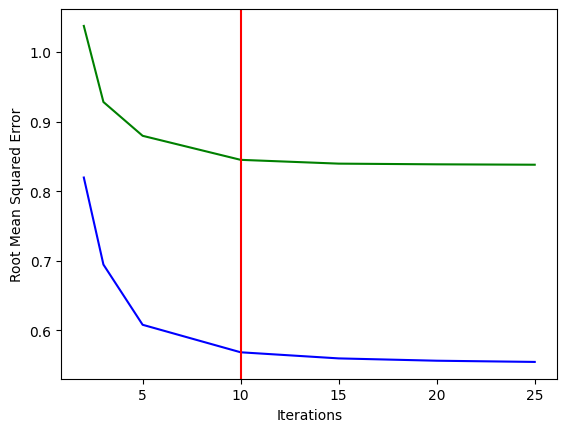

In [3]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

#https://medium.com/@brunoborges_38708/recommender-system-using-als-in-pyspark-10329e1d1ee1
#https://api-docs.databricks.com/python/pyspark/latest/api/pyspark.ml.recommendation.ALS.html

#Splitting the data to be able to train the model
train_data, test_data = RatingsDF.randomSplit([0.9, 0.1], seed=1234)

#Using the ALS model
als = ALS(
    maxIter=10,
    regParam=0.1,
    itemCol="ItemID",
    userCol="UserID",
    ratingCol="Rating",
    coldStartStrategy="drop",
    nonnegative=True
)

#Fitting the training data into the model
model = als.fit(train_data)
predictions = model.transform(test_data)

#create evaluator
evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="Rating",
    predictionCol="prediction"
)

#using RMSE as the mathmatical evaluator of the entire model
rmse=evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) = {rmse}")

#Make 5 recommendations for each user
userRecommendations = model.recommendForAllUsers(5)
userRecommendations.show(truncate=False)


#testing the optimal number of iterations for ALS
tries=[2,3,5,10,15,20,25]
test_rmse=np.zeros((len(tries),1))
train_rmse=np.zeros((len(tries),1))

for i in range(0,len(tries)):
    als = ALS(
        maxIter=tries[i],
        regParam=0.1,
        itemCol="ItemID",
        userCol="UserID",
        ratingCol="Rating",
        coldStartStrategy="drop",
        nonnegative=True
    )

    model = als.fit(train_data)
    train_predictions = model.transform(train_data)
    test_predictions = model.transform(test_data)

    evaluator = RegressionEvaluator(
        metricName="rmse",
        labelCol="Rating",
        predictionCol="prediction"
    )

    train_rmse[i]=evaluator.evaluate(train_predictions)
    test_rmse[i]=evaluator.evaluate(test_predictions)

plt.figure()
plt.xlabel("Iterations")
plt.ylabel("Root Mean Squared Error")
plt.plot(tries, train_rmse, 'b')
plt.plot(tries, test_rmse, 'g')
plt.axvline(x=10, color='r')
plt.show()
